<a href="https://colab.research.google.com/github/krakowiakpawel9/neural-network-course/blob/master/06_cnn/02_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Klasyfikator binarny - Image Classification - Drone vs. Passenger Plane

1. [Import bibliotek](#a0)
2. [Załadowanie danych](#a1)
3. [Przygotowanie zbiorów: treningowego, walidacyjnego i testowego](#a2)
4. [Eksplorcja danych](#a3)
5. [Augmentacja danych](#a4)
6. [Budowa modelu](#a5)
7. [Transfer learning - model VGG16](#a6)
8. [Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw](#a7)
9. [Ocena modelu na zbiorze testowym](#a8)
10. [Wyświetlenie błędów predykcji](#a9)

### <a name='a0'></a> Import bibliotek

In [0]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

TensorFlow 2.x selected.


### <a name='a1'></a> Załadowanie danych

In [0]:
# !wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
# !unzip -q flying-vehicles.zip

--2019-11-14 07:20:30--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip.1’

flying-vehicles.zip  38%[======>             ] 568.01M  49.3MB/s    eta 36s    ^C


### <a name='a2'></a> Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [0]:
!rm -rf ./images

In [0]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [0]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)        

In [0]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [0]:
size = min(len(drone_fnames), len(passenger_fnames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [0]:
# !rm -rf ./images/train/drone/*
# !rm -rf ./images/valid/drone/*
# !rm -rf ./images/test/drone/*
# !rm -rf ./images/train/passenger/*
# !rm -rf ./images/valid/passenger/*
# !rm -rf ./images/test/passenger/*

In [0]:
for i, fname in enumerate(drone_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst) 

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))               

### <a name='a3'></a> Eksplorcja danych

(-0.5, 2047.5, 1364.5, -0.5)

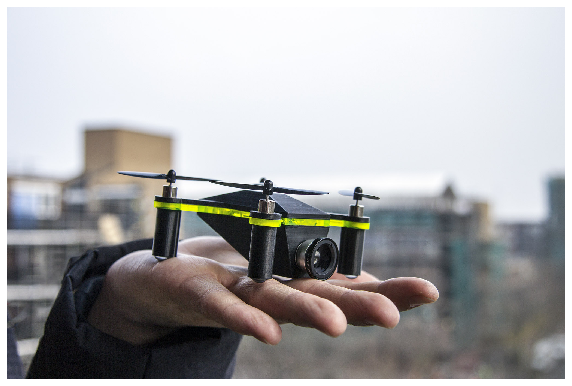

In [0]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 830 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 339.5, 226.5, -0.5)

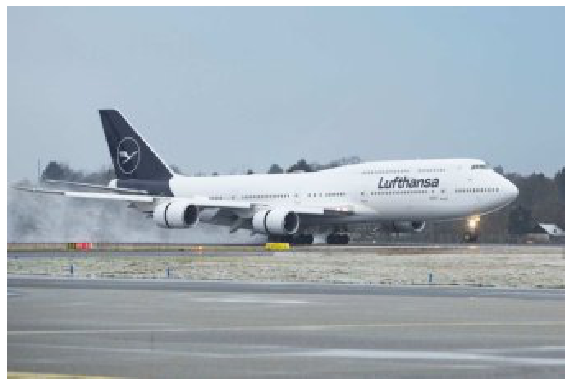

In [0]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 578 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### <a name='a4'></a> Augmentcja danych

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [0]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(20, 14))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

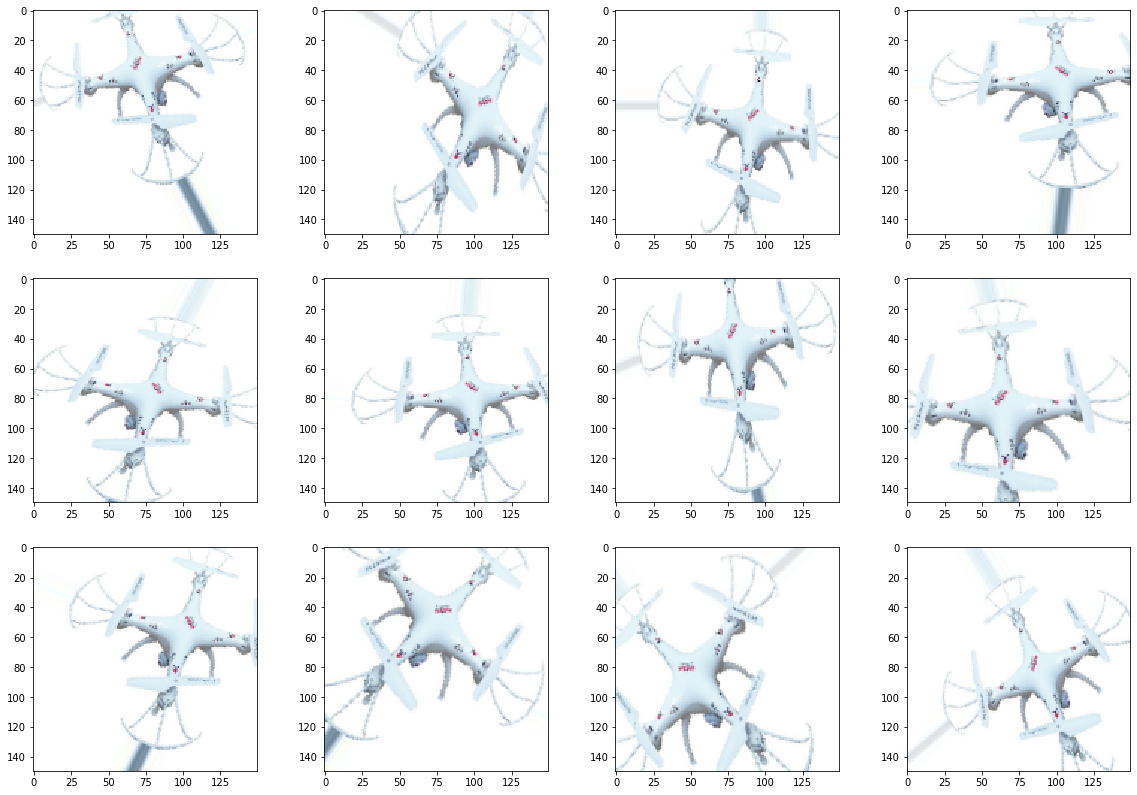

In [0]:
#@title Zbiór treningowy drone:
idx = 86 #@param {type:'slider', min:0, max:919}            
display_augmented_images(train_drone_dir, idx)

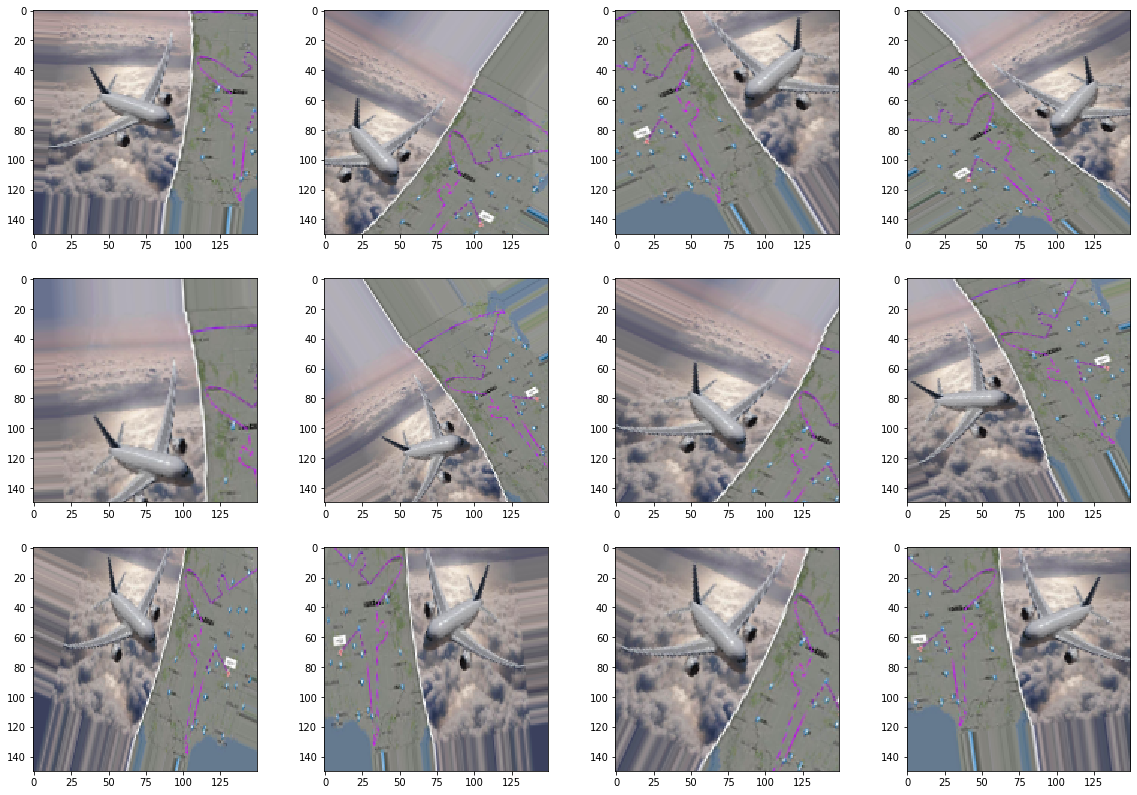

In [0]:
#@title Zbiór treningowy passenger:
idx = 212 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

### <a name='a5'></a> Budowa modelu

In [0]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [0]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [0]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Epoch 1/50
28/28 [==============================] - 29s 1s/step - loss: 0.6959 - accuracy: 0.5228 - val_loss: 0.6939 - val_accuracy: 0.4805
Epoch 2/50
28/28 [==============================] - 23s 837ms/step - loss: 0.6912 - accuracy: 0.5324 - val_loss: 0.6779 - val_accuracy: 0.6328
Epoch 3/50
28/28 [==============================] - 28s 988ms/step - loss: 0.6870 - accuracy: 0.5458 - val_loss: 0.6761 - val_accuracy: 0.5430
Epoch 4/50
28/28 [==============================] - 23s 811ms/step - loss: 0.6838 - accuracy: 0.5649 - val_loss: 0.6576 - val_accuracy: 0.6055
Epoch 5/50
28/28 [==============================] - 27s 980ms/step - loss: 0.6768 - accuracy: 0.5592 - val_loss: 0.6479 - val_accuracy: 0.6367
Epoch 6/50
28/28 [==============================] - 23s 808ms/step - loss: 0.6669 - accuracy: 0.6059 - val_loss: 0.6386 - val_accuracy: 0.6602
Epoch 7/50
28/28 [==============================] - 24s 870ms/step - loss: 0.6515 - accuracy: 0.6183 - val_loss: 0.6619 - val_accuracy: 0.5898
Ep

KeyboardInterrupt: ignored

In [0]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
!tensorboard --logdir logs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.0.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [0]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

NameError: ignored

### <a name='a6'></a> Transfer learning - model VGG16

In [0]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [0]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
print(f'Liczba warstw trenowanych przed zamrożeniem {len(model.trainable_weights)}')
conv_base.trainable = False
print(f'Liczba warstw trenowanych po zamrożeniu {len(model.trainable_weights)}')

Liczba warstw trenowanych przed zamrożeniem 30
Liczba warstw trenowanych po zamrożeniu 4


In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [0]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Epoch 1/50
28/28 [==============================] - 40s 1s/step - loss: 0.6797 - accuracy: 0.6276 - val_loss: 0.5849 - val_accuracy: 0.6680
Epoch 2/50
28/28 [==============================] - 30s 1s/step - loss: 0.5623 - accuracy: 0.7087 - val_loss: 0.4884 - val_accuracy: 0.7422
Epoch 3/50
28/28 [==============================] - 35s 1s/step - loss: 0.5173 - accuracy: 0.7321 - val_loss: 0.5331 - val_accuracy: 0.7227
Epoch 4/50
28/28 [==============================] - 30s 1s/step - loss: 0.4821 - accuracy: 0.7567 - val_loss: 0.4631 - val_accuracy: 0.7578
Epoch 5/50
28/28 [==============================] - 33s 1s/step - loss: 0.4814 - accuracy: 0.7628 - val_loss: 0.4620 - val_accuracy: 0.7656
Epoch 6/50
28/28 [==============================] - 31s 1s/step - loss: 0.4788 - accuracy: 0.7690 - val_loss: 0.4889 - val_accuracy: 0.7617
Epoch 7/50
28/28 [==============================] - 34s 1s/step - loss: 0.4537 - accuracy: 0.7699 - val_loss: 0.4769 - val_accuracy: 0.7695
Epoch 8/50
28/28 [==

In [0]:
import plotly.graph_objects as go
plot_hist(history)

### <a name='a7'></a> Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw

In [0]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_6       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [0]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_6       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [0]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Epoch 1/30
28/28 [==============================] - 37s 1s/step - loss: 0.6428 - accuracy: 0.6116 - val_loss: 0.5583 - val_accuracy: 0.7305
Epoch 2/30
28/28 [==============================] - 29s 1s/step - loss: 0.5682 - accuracy: 0.7009 - val_loss: 0.4984 - val_accuracy: 0.7383
Epoch 3/30
28/28 [==============================] - 35s 1s/step - loss: 0.5127 - accuracy: 0.7377 - val_loss: 0.4860 - val_accuracy: 0.7578
Epoch 4/30
28/28 [==============================] - 31s 1s/step - loss: 0.4687 - accuracy: 0.7699 - val_loss: 0.4597 - val_accuracy: 0.7617
Epoch 5/30
28/28 [==============================] - 35s 1s/step - loss: 0.4503 - accuracy: 0.7790 - val_loss: 0.4450 - val_accuracy: 0.7734
Epoch 6/30
28/28 [==============================] - 31s 1s/step - loss: 0.4393 - accuracy: 0.7946 - val_loss: 0.4257 - val_accuracy: 0.7930
Epoch 7/30
28/28 [==============================] - 33s 1s/step - loss: 0.4143 - accuracy: 0.8025 - val_loss: 0.4161 - val_accuracy: 0.8125
Epoch 8/30
28/28 [==

In [0]:
plot_hist(history)

### <a name='a8'></a> Ocena modelu na zbiorze testowym

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

Found 262 images belonging to 2 classes.


array([0.00462 , 0.00396 , 0.274209, 0.086926, 0.008387, 0.000061,
       0.060648, 0.080153, 0.000121, 0.003087, 0.646093, 0.549838,
       0.041231, 0.007703, 0.000135, 0.001217, 0.933057, 0.173133,
       0.000041, 0.000757, 0.008123, 0.000138, 0.026214, 0.000386,
       0.017857, 0.383171, 0.003495, 0.093411, 0.000776, 0.050368,
       0.000031, 0.536809, 0.131635, 0.047847, 0.128668, 0.000381,
       0.009416, 0.050487, 0.007033, 0.292986, 0.000226, 0.08885 ,
       0.001252, 0.011854, 0.00005 , 0.000248, 0.000268, 0.004552,
       0.002045, 0.252622, 0.000071, 0.447673, 0.43451 , 0.002926,
       0.044078, 0.014357, 0.141752, 0.000538, 0.107613, 0.007021,
       0.001977, 0.02352 , 0.006854, 0.026837, 0.392832, 0.00836 ,
       0.003099, 0.012051, 0.001971, 0.029249, 0.002561, 0.009675,
       0.000959, 0.076976, 0.058705, 0.026616, 0.043056, 0.014199,
       0.768021, 0.143696, 0.30315 , 0.026221, 0.138525, 0.089387,
       0.069581, 0.008668, 0.623878, 0.390764, 0.726495, 0.475

In [0]:
predictions  = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,0.004620,0
1,0.003960,0
2,0.274209,0
3,0.086926,0
4,0.008387,0
...,...,...
257,0.999771,1
258,0.513327,1
259,0.392719,0
260,0.982910,1


In [0]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [0]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1])

In [0]:
test_generator.class_indices

{'drone': 0, 'passenger': 1}

In [0]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[113,  18],
       [ 12, 119]])

In [0]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       131
           1       0.87      0.91      0.89       131

    accuracy                           0.89       262
   macro avg       0.89      0.89      0.89       262
weighted avg       0.89      0.89      0.89       262



### <a name='a9'></a> Wyświetlenie błędów predykcji

In [0]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

,y_true,y_pred
drone/00000019.jpg,0,0
drone/00000022.jpg,0,0
drone/00000032.jpg,0,0
drone/00000036.jpg,0,0
drone/00000058.jpg,0,0
...,...,...
passenger/00001467.jpg,1,1
passenger/00001477.jpg,1,1
passenger/00001479.jpg,1,0
passenger/00001480.jpg,1,1


In [0]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_correct,is_incorrect
drone/00000019.jpg,0,0,True,0
drone/00000022.jpg,0,0,True,0
drone/00000032.jpg,0,0,True,0
drone/00000036.jpg,0,0,True,0
drone/00000058.jpg,0,0,True,0
...,...,...,...,...
passenger/00001467.jpg,1,1,True,0
passenger/00001477.jpg,1,1,True,0
passenger/00001479.jpg,1,0,False,1
passenger/00001480.jpg,1,1,True,0


In [0]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000148.jpg', 'drone/00000150.jpg', 'drone/00000175.jpg',
       'drone/00000334.png', 'drone/00000819.jpg', 'drone/00000890.jpg',
       'drone/00000926.jpg', 'drone/00000949.jpg', 'drone/00000973.jpg',
       'drone/00000990.jpg', 'drone/00001032.jpg', 'drone/00001073.jpg',
       'drone/00001171.jpg', 'drone/00001199.jpg', 'drone/00001270.jpg',
       'drone/00001332.jpg', 'drone/00001343.jpg', 'drone/00001352.jpg',
       'passenger/00000291.png', 'passenger/00000550.jpg',
       'passenger/00000578.png', 'passenger/00000714.jpg',
       'passenger/00000769.jpg', 'passenger/00000792.jpg',
       'passenger/00000810.jpg', 'passenger/00000953.jpg',
       'passenger/00001060.jpg', 'passenger/00001077.jpg',
       'passenger/00001404.JPG', 'passenger/00001479.jpg'],
      dtype='object')

(-0.5, 419.5, 239.5, -0.5)

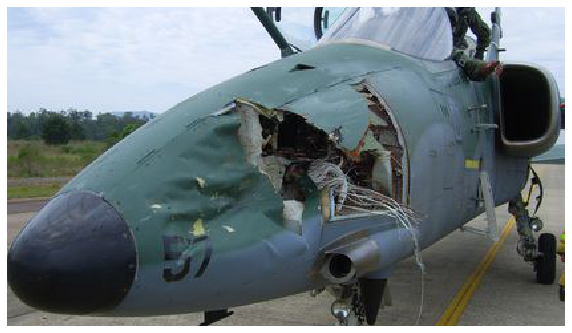

In [0]:
img_path = os.path.join(test_drone_dir, '00001332.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1099.5, 823.5, -0.5)

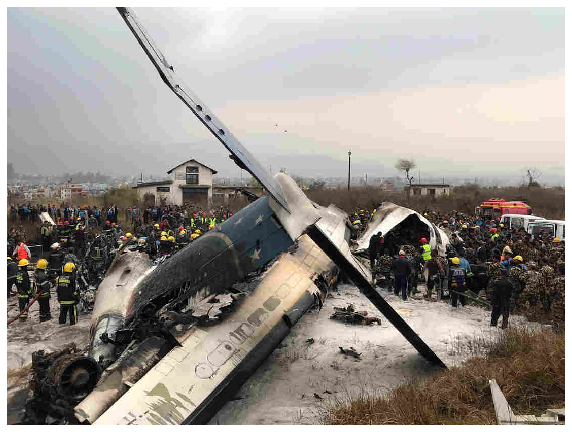

In [0]:
img_path = os.path.join(test_passenger_dir, '00000953.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)